In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
x = np.linspace(0, 1, 100)[:,np.newaxis].astype('float32')
y = np.sin(x) + np.random.normal(0, 0.01, size=x.shape).astype('float32')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

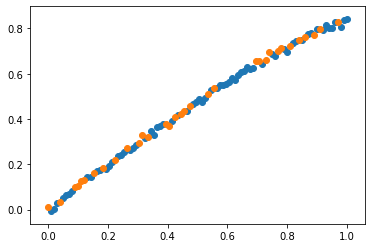

In [6]:
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test)

In [7]:
import data_utils

In [8]:
not True

False

In [9]:

import operator
import os
from typing import Tuple, Iterator, List, Dict
from absl import app
from absl import flags
import numpy as np
import tensorflow.compat.v1 as tf

# from neural_additive_models import data_utils
# from neural_additive_models import graph_builder
import data_utils
import graph_builder

gfile = tf.io.gfile
DatasetType = data_utils.DatasetType

FLAGS = flags.FLAGS


flags.DEFINE_integer('training_epochs', None,
                     'The number of epochs to run training for.')
flags.DEFINE_float('learning_rate', 1e-2, 'Hyperparameter: learning rate.')
flags.DEFINE_float('output_regularization', 0.0, 'Hyperparameter: feature reg')
flags.DEFINE_float('l2_regularization', 0.0, 'Hyperparameter: l2 weight decay')
flags.DEFINE_integer('batch_size', 1024, 'Hyperparameter: batch size.')
flags.DEFINE_string('logdir', None, 'Path to dir where to store summaries.')
flags.DEFINE_string('dataset_name', 'Teleco',
                    'Name of the dataset to load for training.')
flags.DEFINE_float('decay_rate', 0.995, 'Hyperparameter: Optimizer decay rate')
flags.DEFINE_float('dropout', 0.5, 'Hyperparameter: Dropout rate')
flags.DEFINE_integer(
    'data_split', 1, 'Dataset split index to use. Possible '
    'values are 1 to `FLAGS.num_splits`.')
flags.DEFINE_integer('tf_seed', 1, 'seed for tf.')
flags.DEFINE_float('feature_dropout', 0.0,
                   'Hyperparameter: Prob. with which features are dropped')
flags.DEFINE_integer(
    'num_basis_functions', 1000, 'Number of basis functions '
    'to use in a FeatureNN for a real-valued feature.')
flags.DEFINE_integer('units_multiplier', 2, 'Number of basis functions for a '
                     'categorical feature')
flags.DEFINE_boolean(
    'cross_val', False, 'Boolean flag indicating whether to '
    'perform cross validation or not.')
flags.DEFINE_integer(
    'max_checkpoints_to_keep', 1, 'Indicates the maximum '
    'number of recent checkpoint files to keep.')
flags.DEFINE_integer(
    'save_checkpoint_every_n_epochs', 10, 'Indicates the '
    'number of epochs after which an checkpoint is saved')
flags.DEFINE_integer('n_models', 1, 'the number of models to train.')
flags.DEFINE_integer('num_splits', 3, 'Number of data splits to use')
flags.DEFINE_integer('fold_num', 1, 'Index of the fold to be used')
flags.DEFINE_string(
    'activation', 'exu', 'Activation function to used in the '
    'hidden layer. Possible options: (1) relu, (2) exu')
flags.DEFINE_boolean(
    'regression', False, 'Boolean flag indicating whether we '
    'are solving a regression task or a classification task.')
flags.DEFINE_boolean('debug', False, 'Debug mode. Log additional things')
flags.DEFINE_boolean('shallow', False, 'Whether to use shallow or deep NN.')
flags.DEFINE_boolean('use_dnn', False, 'Deep NN baseline.')
flags.DEFINE_integer('early_stopping_epochs', 60, 'Early stopping epochs')
_N_FOLDS = 5
GraphOpsAndTensors = graph_builder.GraphOpsAndTensors
EvaluationMetric = graph_builder.EvaluationMetric

In [10]:

@flags.multi_flags_validator(['data_split', 'cross_val'],
                             message='Data split should not be used in '
                             'conjunction with cross validation')
def data_split_with_cross_validation(flags_dict):
  return (flags_dict['data_split'] == 1) or (not flags_dict['cross_val'])


def _get_train_and_lr_decay_ops(
    graph_tensors_and_ops,
    early_stopping):
  """Returns training and learning rate decay ops."""
  train_ops = [
      g['train_op']
      for n, g in enumerate(graph_tensors_and_ops)
      if not early_stopping[n]
  ]
  lr_decay_ops = [
      g['lr_decay_op']
      for n, g in enumerate(graph_tensors_and_ops)
      if not early_stopping[n]
  ]
  return train_ops, lr_decay_ops


def _update_latest_checkpoint(checkpoint_dir,
                              best_checkpoint_dir):
  """Updates the latest checkpoint in `best_checkpoint_dir` from `checkpoint_dir`."""
  for filename in gfile.glob(os.path.join(best_checkpoint_dir, 'model.*')):
    gfile.remove(filename)
  for name in gfile.glob(os.path.join(checkpoint_dir, 'model.*')):
    gfile.copy(
        name,
        os.path.join(best_checkpoint_dir, os.path.basename(name)),
        overwrite=True)


def _create_computation_graph(
    x_train, y_train, x_validation,
    y_validation, batch_size
):
  """Build the computation graph."""
  graph_tensors_and_ops = []
  metric_scores = []
  for n in range(FLAGS.n_models):
    graph_tensors_and_ops_n, metric_scores_n = graph_builder.build_graph(
        x_train=x_train,
        y_train=y_train,
        x_test=x_validation,
        y_test=y_validation,
        activation=FLAGS.activation,
        learning_rate=FLAGS.learning_rate,
        batch_size=batch_size,
        shallow=FLAGS.shallow,
        output_regularization=FLAGS.output_regularization,
        l2_regularization=FLAGS.l2_regularization,
        dropout=FLAGS.dropout,
        num_basis_functions=FLAGS.num_basis_functions,
        units_multiplier=FLAGS.units_multiplier,
        decay_rate=FLAGS.decay_rate,
        feature_dropout=FLAGS.feature_dropout,
        regression=FLAGS.regression,
        use_dnn=FLAGS.use_dnn,
        trainable=True,
        name_scope=f'model_{n}')
    graph_tensors_and_ops.append(graph_tensors_and_ops_n)
    metric_scores.append(metric_scores_n)
  return graph_tensors_and_ops, metric_scores


def _create_graph_saver(graph_tensors_and_ops,
                        logdir, num_steps_per_epoch):
  """Create saving hook(s) as well as model and checkpoint directories."""
  saver_hooks, model_dirs, best_checkpoint_dirs = [], [], []
  save_steps = num_steps_per_epoch * FLAGS.save_checkpoint_every_n_epochs
  # The MonitoredTraining Session counter increments by `n_models`
  save_steps = save_steps * FLAGS.n_models
  for n in range(FLAGS.n_models):
    scaffold = tf.train.Scaffold(
        saver=tf.train.Saver(
            var_list=graph_tensors_and_ops[n]['nn_model'].trainable_variables,
            save_relative_paths=True,
            max_to_keep=FLAGS.max_checkpoints_to_keep))
    model_dirs.append(os.path.join(logdir, 'model_{}').format(n))
    best_checkpoint_dirs.append(os.path.join(model_dirs[-1], 'best_checkpoint'))
    gfile.makedirs(best_checkpoint_dirs[-1])
    saver_hook = tf.train.CheckpointSaverHook(
        checkpoint_dir=model_dirs[-1], save_steps=save_steps, scaffold=scaffold)
    saver_hooks.append(saver_hook)
  return saver_hooks, model_dirs, best_checkpoint_dirs


def _update_metrics_and_checkpoints(sess,
                                    epoch,
                                    metric_scores,
                                    curr_best_epoch,
                                    best_validation_metric,
                                    best_train_metric,
                                    model_dir,
                                    best_checkpoint_dir,
                                    metric_name = 'RMSE'):
  """Update metric scores and latest checkpoint."""
  # Minimize RMSE and maximize AUROC
  compare_metric = operator.lt if FLAGS.regression else operator.gt
  # Calculate the AUROC/RMSE on the validation split
  validation_metric = metric_scores['test'](sess)
  if FLAGS.debug:
    tf.logging.info('Epoch %d %s Val %.4f', epoch, metric_name,
                    validation_metric)
  if compare_metric(validation_metric, best_validation_metric):
    curr_best_epoch = epoch
    best_validation_metric = validation_metric
    best_train_metric = metric_scores['train'](sess)
    # copy the checkpoints files *.meta *.index, *.data* each time
    # there is a better result
    _update_latest_checkpoint(model_dir, best_checkpoint_dir)
  return curr_best_epoch, best_validation_metric, best_train_metric


def training(x_train, y_train, x_validation,
             y_validation,
             logdir):
  """Trains the Neural Additive Model (NAM).
  Args:
    x_train: Training inputs.
    y_train: Training labels.
    x_validation: Validation inputs.
    y_validation: Validation labels.
    logdir: dir to save the checkpoints.
  Returns:
    Best train and validation evaluation metric obtained during NAM training.
  """
  tf.logging.info('Started training with logdir %s', logdir)
  batch_size = min(FLAGS.batch_size, x_train.shape[0])
  num_steps_per_epoch = x_train.shape[0] // batch_size
  # Keep track of the best validation RMSE/AUROC and train AUROC score which
  # corresponds to the best validation metric score.
  if FLAGS.regression:
    best_train_metric = np.inf * np.ones(FLAGS.n_models)
    best_validation_metric = np.inf * np.ones(FLAGS.n_models)
  else:
    best_train_metric = np.zeros(FLAGS.n_models)
    best_validation_metric = np.zeros(FLAGS.n_models)
  # Set to a large value to avoid early stopping initially during training
  curr_best_epoch = np.full(FLAGS.n_models, np.inf)
  # Boolean variables to indicate whether the training of a specific model has
  # been early stopped.
  early_stopping = [False] * FLAGS.n_models
  # Classification: AUROC, Regression : RMSE Score
  metric_name = 'RMSE' if FLAGS.regression else 'AUROC'
  tf.reset_default_graph()
  with tf.Graph().as_default():
    tf.compat.v1.set_random_seed(FLAGS.tf_seed)
    # Setup your training.
    graph_tensors_and_ops, metric_scores = _create_computation_graph(
        x_train, y_train, x_validation, y_validation, batch_size)

    train_ops, lr_decay_ops = _get_train_and_lr_decay_ops(
        graph_tensors_and_ops, early_stopping)
    global_step = tf.train.get_or_create_global_step()
    increment_global_step = tf.assign(global_step, global_step + 1)
    saver_hooks, model_dirs, best_checkpoint_dirs = _create_graph_saver(
        graph_tensors_and_ops, logdir, num_steps_per_epoch)
    if FLAGS.debug:
      summary_writer = tf.summary.FileWriter(os.path.join(logdir, 'tb_log'))

    with tf.train.MonitoredSession(hooks=saver_hooks) as sess:
      for n in range(FLAGS.n_models):
        sess.run([
            graph_tensors_and_ops[n]['iterator_initializer'],
            graph_tensors_and_ops[n]['running_vars_initializer']
        ])
      for epoch in range(1, FLAGS.training_epochs + 1):
        if not all(early_stopping):
          for _ in range(num_steps_per_epoch):
            sess.run(train_ops)  # Train the network
          # Decay the learning rate by a fixed ratio every epoch
          sess.run(lr_decay_ops)
        else:
          tf.logging.info('All models early stopped at epoch %d', epoch)
          break

        for n in range(FLAGS.n_models):
          if early_stopping[n]:
            sess.run(increment_global_step)
            continue
          # Log summaries
          if FLAGS.debug:
            global_summary, global_step = sess.run([
                graph_tensors_and_ops[n]['summary_op'],
                graph_tensors_and_ops[n]['global_step']
            ])
            summary_writer.add_summary(global_summary, global_step)

          if epoch % FLAGS.save_checkpoint_every_n_epochs == 0:
            (curr_best_epoch[n], best_validation_metric[n],
             best_train_metric[n]) = _update_metrics_and_checkpoints(
                 sess, epoch, metric_scores[n], curr_best_epoch[n],
                 best_validation_metric[n], best_train_metric[n], model_dirs[n],
                 best_checkpoint_dirs[n], metric_name)
            if curr_best_epoch[n] + FLAGS.early_stopping_epochs < epoch:
              tf.logging.info('Early stopping at epoch {}'.format(epoch))
              early_stopping[n] = True  # Set early stopping for model `n`.
              train_ops, lr_decay_ops = _get_train_and_lr_decay_ops(
                  graph_tensors_and_ops, early_stopping)
          # Reset running variable counters
          sess.run(graph_tensors_and_ops[n]['running_vars_initializer'])

  tf.logging.info('Finished training.')
  for n in range(FLAGS.n_models):
    tf.logging.info(
        'Model %d: Best Epoch %d, Individual %s: Train %.4f, Validation %.4f',
        n, curr_best_epoch[n], metric_name, best_train_metric[n],
        best_validation_metric[n])

  return np.mean(best_train_metric), np.mean(best_validation_metric)


def create_test_train_fold(
    fold_num
):
  """Splits the dataset into training and held-out test set."""
  data_x, data_y, _ = data_utils.load_dataset(FLAGS.dataset_name)
  tf.logging.info('Dataset: %s, Size: %d', FLAGS.dataset_name, data_x.shape[0])
  tf.logging.info('Cross-val fold: %d/%d', FLAGS.fold_num, _N_FOLDS)
  # Get the training and test set based on the StratifiedKFold split
  (x_train_all, y_train_all), test_dataset = data_utils.get_train_test_fold(
      data_x,
      data_y,
      fold_num=fold_num,
      num_folds=_N_FOLDS,
      stratified=not FLAGS.regression)
  data_gen = data_utils.split_training_dataset(
      x_train_all,
      y_train_all,
      FLAGS.num_splits,
      stratified=not FLAGS.regression)
  return data_gen, test_dataset


def single_split_training(data_gen,
                          logdir):
  """Uses a specific (training, validation) split for NAM training."""
  for _ in range(FLAGS.data_split):
    (x_train, y_train), (x_validation, y_validation) = next(data_gen)
  curr_logdir = os.path.join(logdir, 'fold_{}',
                             'split_{}').format(FLAGS.fold_num,
                                                FLAGS.data_split)
  training(x_train, y_train, x_validation, y_validation, curr_logdir)


In [11]:
FLAGS(["--batch_size 64"])

['--batch_size 64']

In [12]:
FLAGS.batch_size

1024

In [13]:
data_gen = data_utils.split_training_dataset(
  X_train,
  y_train,
  1,
  stratified=False)

In [14]:
(X_train, y_train), (X_test, y_test) = next(data_gen)

In [15]:
training(X_train, y_train, X_test, y_test, "log_dir")

INFO:tensorflow:Started training with logdir log_dir
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "nam"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_nn (FeatureNN)       multiple                  9832      
Total params: 9,833
Trainable params: 9,833
Non-trainable 

InvalidArgumentError: buffer_size must be greater than zero.
	 [[node ShuffleAndRepeatDataset_1 (defined at /Users/spx8sk/work/projects/nam/neural_additive_models/graph_builder.py:245) ]]

Errors may have originated from an input operation.
Input Source operations connected to node ShuffleAndRepeatDataset_1:
 TensorSliceDataset_1 (defined at /Users/spx8sk/work/projects/nam/neural_additive_models/graph_builder.py:244)

Original stack trace for 'ShuffleAndRepeatDataset_1':
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
    handle._run()
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-0bdcb0fb889a>", line 1, in <module>
    training(X_train, y_train, X_test, y_test, "log_dir")
  File "<ipython-input-10-21f3d60ee768>", line 155, in training
    x_train, y_train, x_validation, y_validation, batch_size)
  File "<ipython-input-10-21f3d60ee768>", line 64, in _create_computation_graph
    name_scope=f'model_{n}')
  File "/Users/spx8sk/work/projects/nam/neural_additive_models/graph_builder.py", line 332, in build_graph
    ds_tensors = create_balanced_dataset(x_train, y_train, batch_size)
  File "/Users/spx8sk/work/projects/nam/neural_additive_models/graph_builder.py", line 245, in create_balanced_dataset
    tf.data.experimental.shuffle_and_repeat(buffer_size=len(neg[0])))
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 2450, in apply
    return DatasetV1Adapter(super(DatasetV1, self).apply(transformation_func))
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1804, in apply
    dataset = transformation_func(self)
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/tensorflow/python/data/experimental/ops/shuffle_ops.py", line 107, in _apply_fn
    return _ShuffleAndRepeatDataset(dataset, buffer_size, count, seed)
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/tensorflow/python/data/experimental/ops/shuffle_ops.py", line 49, in __init__
    **self._flat_structure)
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 5528, in shuffle_and_repeat_dataset
    output_shapes=output_shapes, name=name)
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 744, in _apply_op_helper
    attrs=attr_protos, op_def=op_def)
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3327, in _create_op_internal
    op_def=op_def)
  File "/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1791, in __init__
    self._traceback = tf_stack.extract_stack()
